In [1]:
import networkx as nx
from fa2 import ForceAtlas2  #the package should be installed before
import matplotlib.pyplot as plt
from datetime import datetime
from statistics import mean, median, quantiles
from networkx.algorithms.traversal.breadth_first_search import descendants_at_distance
import time
import requests
import glob
import pickle
from scipy.ndimage.filters import gaussian_filter1d


In [2]:
def plot_aut_spec(over_time_quantiles,subreddit):
    f, axarr = plt.subplots(1, 6, figsize=(20, 4))
    f.suptitle('Distribution of author specific features for '+subreddit)
    ax_flat = axarr.flatten()
    bins = list(over_time_quantiles.keys())
    
    for i, attr in enumerate(over_time_quantiles[0]["authorStats"]):
        #print(attr)
        elements25 = []
        elements50 = []
        elements75 = []
        for bin_el in over_time_quantiles:
            elements25.append(over_time_quantiles[bin_el]["authorStats"][attr]["25"])
            elements50.append(over_time_quantiles[bin_el]["authorStats"][attr]["50"])
            elements75.append(over_time_quantiles[bin_el]["authorStats"][attr]["75"])
        #print(attr,": ",elements25)
        
        smoothed25 = gaussian_filter1d(elements25, sigma=2)
        smoothed50 = gaussian_filter1d(elements50, sigma=2)
        smoothed75 = gaussian_filter1d(elements75, sigma=2)


        ax_flat[i].plot(bins,smoothed25,"b--")
        ax_flat[i].plot(bins,smoothed50,"r")
        ax_flat[i].plot(bins,smoothed75,"b--")
        ax_flat[i].fill_between(bins, smoothed25, smoothed50, alpha=0.1, color='b')
        ax_flat[i].fill_between(bins, smoothed50, smoothed75, alpha=0.1, color='b')
        ax_flat[i].set_title(attr)

In [3]:
def plot_time_feat(over_time_dict,subreddit):
    f, axarr = plt.subplots(1, 4, figsize=(20, 4))
    f.suptitle('Distribution of temporal features for '+subreddit)
    ax_flat = axarr.flatten()
    bins = list(over_time_dict.keys())
    
    for i, attr in enumerate(over_time_quantiles[0]["timeStats"]):
        #print(attr)
        elements25 = []
        elements50 = []
        elements75 = []
        for bin_el in over_time_quantiles:
            elements25.append(over_time_quantiles[bin_el]["timeStats"][attr]["25"]/86400)
            elements50.append(over_time_quantiles[bin_el]["timeStats"][attr]["50"]/86400)
            elements75.append(over_time_quantiles[bin_el]["timeStats"][attr]["75"]/86400)
        #print(attr,": ",elements25)
        
        smoothed25 = gaussian_filter1d(elements25, sigma=2)
        smoothed50 = gaussian_filter1d(elements50, sigma=2)
        smoothed75 = gaussian_filter1d(elements75, sigma=2)


        ax_flat[i].plot(bins,smoothed25,"b--")
        ax_flat[i].plot(bins,smoothed50,"r")
        ax_flat[i].plot(bins,smoothed75,"b--")
        ax_flat[i].fill_between(bins, smoothed25, smoothed50, alpha=0.1, color='b')
        ax_flat[i].fill_between(bins, smoothed50, smoothed75, alpha=0.1, color='b')
        ax_flat[i].set_title(attr)

In [4]:
def plot_submis_feat(over_time_dict,subreddit):
    f, axarr = plt.subplots(1, 4, figsize=(20, 4))
    f.suptitle('Distribution of submission features for '+subreddit)
    ax_flat = axarr.flatten()
    bins = list(over_time_dict.keys())
    
    for i, attr in enumerate(over_time_quantiles[0]["commStats"]):
        #print(attr)
        elements25 = []
        elements50 = []
        elements75 = []
        for bin_el in over_time_quantiles:
            elements25.append(over_time_quantiles[bin_el]["commStats"][attr]["25"])
            elements50.append(over_time_quantiles[bin_el]["commStats"][attr]["50"])
            elements75.append(over_time_quantiles[bin_el]["commStats"][attr]["75"])
        #print(attr,": ",elements25)
        
        smoothed25 = gaussian_filter1d(elements25, sigma=2)
        smoothed50 = gaussian_filter1d(elements50, sigma=2)
        smoothed75 = gaussian_filter1d(elements75, sigma=2)


        ax_flat[i].plot(bins,smoothed25,"b--",)
        ax_flat[i].plot(bins,smoothed50,"r")
        ax_flat[i].plot(bins,smoothed75,"b--")
        ax_flat[i].fill_between(bins, smoothed25, smoothed50, alpha=0.1, color='b')
        ax_flat[i].fill_between(bins, smoothed50, smoothed75, alpha=0.1, color='b')
        ax_flat[i].set_title(attr)

In [26]:
statCov = {}
#subreddit = "puppies"
subreddit = "PoliticalDiscussion"
autNets = glob.glob("aG_enrich_monthly_"+subreddit+"/total/*")
#autNets = glob.glob("ag_LGBTQ/*")
commNets = glob.glob("cG_enrich_monthly_"+subreddit+"/total/*")

with open('stat_'+subreddit+'_total.pickle', 'rb') as handle:
    allStat = pickle.load(handle)
    

In [27]:
initial_moment = 1561939200 #01-07-2019
#bin_period = 86400 #one day
bin_period = 604800 #one week
#bin_period = 2*bin_period
#bin_period = bin_period*30
final_moment = 1625097600 #01-07-2021
over_time_dict = {}
over_time_quantiles = {}

In [28]:
for i in range(-(final_moment-initial_moment)//-bin_period+1): #ceiling division
    over_time_dict[i] = {
        "authorStats":{"num_users":[], "num_edges":[],"size_largest_conn_comp":[],"recip_value":[], "diam":[],"clust_coeff":[]},
        "timeStats" : {"lifeTime":[],"averageTime":[],"medianTime":[],"lifetime95":[]},
        "commStats" : {"num_comments":[],"num_direct_comments":[],"max_depth":[],"H_index":[]} 
    }

for i in range(-(final_moment-initial_moment)//-bin_period+1): #ceiling division
    over_time_quantiles[i] = {
        "authorStats":{"num_users":{}, "num_edges":{},"size_largest_conn_comp":{},"recip_value":{}, "diam":{},"clust_coeff":{}},
        "timeStats" : {"lifeTime":{},"averageTime":{},"medianTime":{},"lifetime95":{}},
        "commStats" : {"num_comments":{},"num_direct_comments":{},"max_depth":{},"H_index":{}} 
    }

In [29]:
num_min = 1000
for el in allStat:
    bin_el = (allStat[el]["created"]-initial_moment)//bin_period
    for k in allStat[el]:
        if k != "created":
            for key in allStat[el][k]:
                over_time_dict[bin_el][k][key].append(allStat[el][k][key])

#for el in over_time_dict:
#    for k in over_time_dict[el]:
#        for key in over_time_dict[el][k]:
#            if len(over_time_dict[el][k][key]) < num_min:
#                num_min = len(over_time_dict[el][k][key])

In [30]:
for k in over_time_dict:
    for key in over_time_dict[k]:
        for attr in over_time_dict[k][key]:
            if len(over_time_dict[k][key][attr])>0:
                quants = quantiles(over_time_dict[k][key][attr],n=4)
                #if attr=="num_users":
                    #print(quants)

In [31]:
for k in over_time_dict:
    for key in over_time_dict[k]:
        for attr in over_time_dict[k][key]:
            if len(over_time_dict[k][key][attr])>0:
                quants = quantiles(over_time_dict[k][key][attr],n=4)
                over_time_quantiles[k][key][attr]["25"] = quants[0]
                over_time_quantiles[k][key][attr]["50"] = quants[1]
                over_time_quantiles[k][key][attr]["75"] = quants[2]
            else:
                over_time_quantiles[k][key][attr]["25"] = 0
                over_time_quantiles[k][key][attr]["50"] = 0
                over_time_quantiles[k][key][attr]["75"] = 0

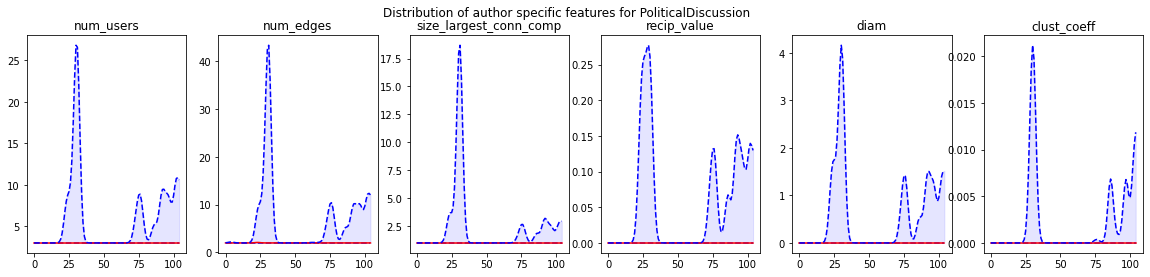

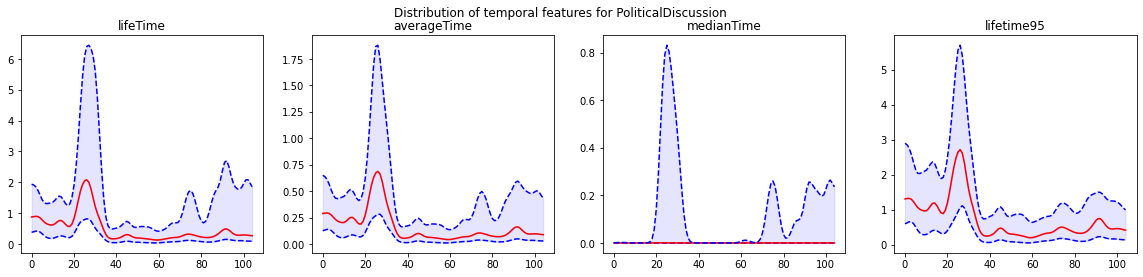

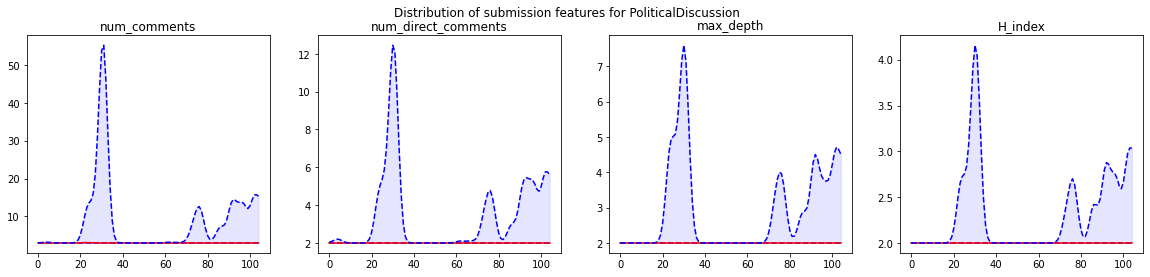

In [32]:
plot_aut_spec(over_time_quantiles, subreddit)
plot_time_feat(over_time_quantiles, subreddit)
plot_submis_feat(over_time_quantiles, subreddit)

In [ ]:
#relation with num users over time? Num comments?

In [42]:
over_time_dict.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25])

In [ ]:
for i,net in enumerate(autNets):
    if i%500 == 0:
        print(i,"/",len(autNets))
    netId = net.split("_")[2]

In [8]:
dicts = allStat.items()
dicts.sort(key=lambda (k): (d['created']))

SyntaxError: invalid syntax (<ipython-input-8-6efb6cc862e8>, line 2)

In [20]:
#autNets

In [15]:
authorGraph = nx.read_gpickle(autNets[0])
commentGraph = nx.read_gpickle(commNets[0])

In [6]:
authorGraph.nodes()

NodeView(('8wo9tdf0', '5mlm5'))

In [7]:
authorGraph['8wo9tdf0']

AtlasView({})

In [12]:
print(authorGraph.graph["num_users"])
print(authorGraph.graph["num_edges"])
print(authorGraph.graph["size_largest_conn_comp"])
print(authorGraph.graph["recip_value"])
print(authorGraph.graph["diam"])
print(authorGraph.graph["clust_coeff"])

2
1
1
0.0
0
0.0


In [16]:
print(commentGraph.graph["lifeTime"])
print(commentGraph.graph["averageTime"])
print(commentGraph.graph["medianTime"])
print(commentGraph.graph["lifetime95"])
    
print(commentGraph.graph["num_comments"])
print(commentGraph.graph["num_direct_comments"])
print(commentGraph.graph["max_depth"])
print(commentGraph.graph["H_index"])

0
0
0
0
1
0
1
1
